# How to implement a neural network (2/5) - classification

This second part will cover the logistic classification model, how to implement and fit it in Python and NumPy, and how to train the model on example data.

While the [previous section]({% post_url /blog/neural_net_implementation/2015-06-12-neural-network-implementation-part01 %}) described a very simple one-input-one-output linear regression model, this tutorial will describe a binary classification neural network with two input dimensions. This model is also known in statistics as the [logistic regression](http://en.wikipedia.org/wiki/Logistic_regression) model. The logistic regression model will be approached as a minimal classification neural network. The model will be optimized using gradient descent, for which the gradient derivations are provided.

This network can be represented graphically as:

![Image of the classification network](/images/neural_net_implementation/SimpleANN02.png)

This is the second part of a 5-part tutorial on how to implement neural networks from scratch in Python:
- [Part 1: Gradient descent]({% post_url /blog/neural_net_implementation/2015-06-12-neural-network-implementation-part01 %})
- [Part 2: Classification (this)]({% post_url /blog/neural_net_implementation/2015-06-13-neural-network-implementation-part02 %})
- [Part 3: Hidden layers trained by backpropagation]({% post_url /blog/neural_net_implementation/2015-06-14-neural-network-implementation-part03 %})
- [Part 4: Vectorization of the operations]({% post_url /blog/neural_net_implementation/2015-06-15-neural-network-implementation-part04 %})
- [Part 5: Generalization to multiple layers]({% post_url /blog/neural_net_implementation/2015-06-16-neural-network-implementation-part05 %})

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)
#

## Define the class distributions

In this example the target classes $t$ will be generated from 2 class distributions: blue circles ($t=1$) and red stars ($t=0$). Samples from both classes are sampled from their respective distributions. These samples are plotted in the figure below.
Note that $\mathbf{t}$ is a $N \times 1$ vector of target values $t_i$, and $X$ is a corresponding $N \times 2$ matrix of individual input samples $[x_{ai}, x_{bi}]$. In what follows we will also sometimes refer to the $i$-th sample of $X$ as $\mathbf{x}_i$ which is a vector of size $2$.

In [2]:
# Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
red_mean = (-1., 0.)  # The mean of the red class
blue_mean = (1., 0.)  # The mean of the blue class
# Generate samples from both classes
x_red = np.random.randn(nb_of_samples_per_class, 2) + red_mean
x_blue = np.random.randn(nb_of_samples_per_class, 2)  + blue_mean

# Merge samples in set of input variables x, and corresponding 
# set of output variables t
X = np.vstack((x_red, x_blue))
t = np.vstack((np.zeros((nb_of_samples_per_class,1)), 
               np.ones((nb_of_samples_per_class,1))))
#

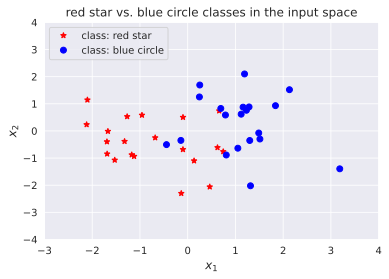

In [3]:
# Plot both classes on the x1, x2 plane
plt.figure(figsize=(6, 4))
plt.plot(x_red[:,0], x_red[:,1], 'r*', label='class: red star')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class: blue circle')
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-3, 4, -4, 4])
plt.title('red star vs. blue circle classes in the input space')
plt.show()
#

## Logistic function and cross-entropy loss function

### Logistic function

The goal is to predict the target class $t_i$ from the input values $\mathbf{x}_i$. The network is defined as having an input $\mathbf{x}_i = [x_{ai}, x_{bi}]$ which gets transformed by the weights $\mathbf{w} = [w_a, w_b]$ to generate the probability that sample $\mathbf{x}_i$ belongs to class $t_i = 1$. This probability $P(t_i=1| \mathbf{x}_i,\mathbf{w})$ is represented by the output $y_i$ of the network computed as $y_i = \sigma(\mathbf{x}_i \cdot \mathbf{w}^T)$. $\sigma$ is the [logistic function](http://en.wikipedia.org/wiki/Logistic_function) and is defined as:
$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

The logistic function is implemented below by the `logistic(z)` method below.


### Cross-entropy loss function

The loss function used to optimize the classification is the [cross-entropy error function](http://en.wikipedia.org/wiki/Cross_entropy). And is defined for sample $i$ as:

$$ \xi(t_i,y_i) = -t_i log(y_i) - (1-t_i)log(1-y_i) $$

Which will give $\xi(t,y) = - \frac{1}{N} \sum_{i=1}^{n} \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right]$ if we average over all $N$ samples.

The loss function is implemented below by the `loss(y, t)` method, and its output with respect to the parameters $\mathbf{w}$ over all samples $X$ is plotted in the figure below.

The neural network output is implemented by the `nn(x, w)` method, and the neural network prediction by the `nn_predict(x,w)` method.


The logistic function with the cross-entropy loss function and the derivatives are explained in detail in the tutorial on the [logistic classification with cross-entropy]({% post_url /blog/cross_entropy/2015-06-10-cross-entropy-logistic %}).

In [4]:
# Define the logistic function
def logistic(z): 
    return 1. / (1 + np.exp(-z))

# Define the neural network function y = 1 / (1 + numpy.exp(-x*w))
def nn(x, w): 
    return logistic(x.dot(w.T))

# Define the neural network prediction function that only returns
#  1 or 0 depending on the predicted class
def nn_predict(x,w): 
    return np.around(nn(x,w))
    
# Define the loss function
def loss(y, t):
    return - np.mean(
        np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

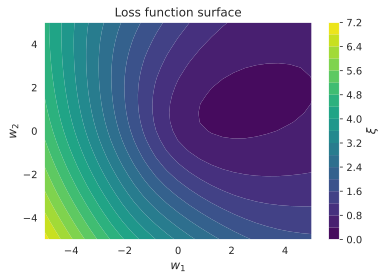

In [5]:
# Plot the loss in function of the weights
# Define a vector of weights for which we want to plot the loss
nb_of_ws = 25 # compute the loss nb_of_ws times in each dimension
wsa = np.linspace(-5, 5, num=nb_of_ws) # weight a
wsb = np.linspace(-5, 5, num=nb_of_ws) # weight b
ws_x, ws_y = np.meshgrid(wsa, wsb) # generate grid
loss_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize loss matrix
# Fill the loss matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        loss_ws[i,j] = loss(
            nn(X, np.asmatrix([ws_x[i,j], ws_y[i,j]])) , t)
# Plot the loss function surface
plt.figure(figsize=(6, 4))
plt.contourf(ws_x, ws_y, loss_ws, 20, cmap=cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel('$\\xi$', fontsize=12)
plt.xlabel('$w_1$', fontsize=12)
plt.ylabel('$w_2$', fontsize=12)
plt.title('Loss function surface')
plt.grid()
plt.show()
#

## Gradient descent optimization of the loss function

The gradient descent algorithm works by taking the [gradient](http://en.wikipedia.org/wiki/Gradient) ([derivative](http://en.wikipedia.org/wiki/Derivative)) of the loss function $\xi$ with respect to the parameters $\mathbf{w}$, and updates the parameters in the direction of the negative gradient (down along the loss function).

The parameters $\mathbf{w}$ are updated every iteration $k$ by taking steps proportional to the negative of the gradient: $\mathbf{w}(k+1) = \mathbf{w}(k) - \Delta \mathbf{w}(k+1)$. $\Delta \mathbf{w}$ is defined as: $\Delta \mathbf{w} = \mu \frac{\partial \xi}{\partial \mathbf{w}}$ with $\mu$ the learning rate.

Following the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) then ${\partial \xi_i}/{\partial \mathbf{w}}$, for each sample $i$ can be computed as follows:

$$
\frac{\partial \xi_i}{\partial \mathbf{w}} = \frac{\partial \xi_i}{\partial y_i} \frac{\partial y_i}{\partial z_i} \frac{\partial z_i}{\partial \mathbf{w}}
$$

Where $y_i = \sigma(z_i)$ is the output of the logistic neuron, and $z_i = \mathbf{x}_i \cdot \mathbf{w}^T$ the input to the logistic neuron. 

* ${\partial \xi_i}/{\partial y_i}$ can be calculated as (see [this post]({% post_url /blog/cross_entropy/2015-06-10-cross-entropy-logistic %}) for the derivation):

$$
\frac{\partial \xi_i}{\partial y_i} = \frac{y_i - t_i}{y_i (1 - y_i)}
$$


* ${\partial y_i}/{\partial z_i}$ can be calculated as (see [this post]({% post_url /blog/cross_entropy/2015-06-10-cross-entropy-logistic %}) for the derivation):

$$
\frac{\partial y_i}{\partial z_i} = y_i (1 - y_i)
$$

* ${\partial z_i}/{\partial \mathbf{w}}$ can be calculated as:

$$
\frac{\partial z_i}{\partial \mathbf{w}} = \frac{\partial (\mathbf{x}_i \cdot \mathbf{w})}{\partial \mathbf{w}} = \mathbf{x}_i
$$

Bringing this together we can write:

$$
\frac{\partial \xi_i}{\partial \mathbf{w}} 
= \frac{\partial \xi_i}{\partial y_i} \frac{\partial y_i}{\partial z_i} \frac{\partial z_i}{\partial \mathbf{w}} 
= \mathbf{x}_i \cdot y_i (1 - y_i) \cdot \frac{y_i - t_i}{y_i (1-y_i)} 
= \mathbf{x}_i \cdot (y_i-t_i) 
$$

Notice how this gradient is the same (negating the constant factor) as the gradient of the squared error regression from previous section.

So the full update function $\Delta \mathbf{w}$ for the weights will become:

$$
\Delta \mathbf{w} = \mu \cdot \frac{\partial \xi_i}{\partial \mathbf{w}} = \mu \cdot \mathbf{x}_i \cdot (y_i - t_i)
$$

In the batch processing, we just average all the gradients for each sample:

$$\Delta \mathbf{w} = \mu \cdot \frac{1}{N} \sum_{i=1}^{N} \mathbf{x}_i (y_i - t_i)$$

To start out the gradient descent algorithm, you typically start with picking the initial parameters at random and start updating these parameters according to the delta rule with $\Delta \mathbf{w}$ until convergence.

The gradient ${\partial \xi}/{\partial \mathbf{w}}$ is implemented by the `gradient(w, x, t)` function. $\Delta \mathbf{w}$ is computed by the `delta_w(w_k, x, t, learning_rate)`. 

In [6]:
def gradient(w, x, t):
    """Gradient function."""
    return (nn(x, w) - t).T * x

 
def delta_w(w_k, x, t, learning_rate):
    """Update function which returns the update for each 
    weight {w_a, w_b} in a vector."""
    return learning_rate * gradient(w_k, x, t)

### Gradient descent updates

Gradient descent is run on the example inputs $X$ and targets $\mathbf{t}$ for 10 iterations.
The first 3 iterations are shown in the figure below. The blue dots represent the weight parameter values $\mathbf{w}(k)$ at iteration $k$.

In [7]:
# Set the initial weight parameter
w = np.asmatrix([-4, -2])  # Randomly decided
# Set the learning rate
learning_rate = 0.05

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 10  # Number of gradient descent updates
w_iter = [w]  # List to store the weight values over the iterations
for i in range(nb_of_iterations):
    dw = delta_w(w, X, t, learning_rate)  # Get the delta w update
    w = w - dw  # Update the weights
    w_iter.append(w)  # Store the weights for plotting

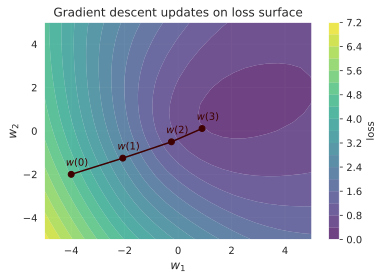

In [8]:
# Plot the first weight updates on the error surface
# Plot the error surface
plt.figure(figsize=(6, 4))
plt.contourf(ws_x, ws_y, loss_ws, 20, alpha=0.75, cmap=cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel('loss')

# Plot the updates
for i in range(1, 4): 
    w1 = w_iter[i-1]
    w2 = w_iter[i]
    # Plot the weight-loss values that represents the update
    plt.plot(w1[0,0], w1[0,1], marker='o', color='#3f0000')  # Plot the weight-loss value
    plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], linestyle='-', color='#3f0000')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, f'$w({i-1})$', color='#3f0000')
# Plot the last weight
w1 = w_iter[3]  
plt.plot(w1[0,0], w1[0,1], marker='o', color='#3f0000')
plt.text(w1[0,0]-0.2, w1[0,1]+0.4, f'$w({i})$', color='#3f0000') 
# Show figure
plt.xlabel('$w_1$', fontsize=12)
plt.ylabel('$w_2$', fontsize=12)
plt.title('Gradient descent updates on loss surface')
plt.show()
#

## Visualization of the trained classifier

The resulting decision boundary of running gradient descent on the example inputs $X$ and targets $\mathbf{t}$ is shown in the figure below. The background color refers to the classification decision of the trained classifier. Note that since this decision plane is linear that not all examples can be classified correctly. Two blue circles will be misclassified as red star, and four red stars will be misclassified as blue circles.

Note that the decision boundary goes through the point $(0,0)$ since we don't have a bias parameter on the logistic output unit.

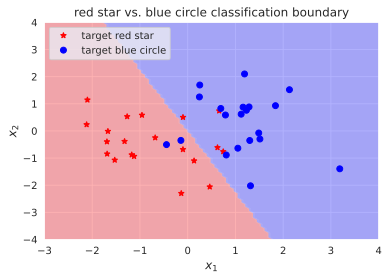

In [9]:
# Plot the resulting decision boundary
plt.figure(figsize=(6, 4))
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xsa = np.linspace(-4, 4, num=nb_of_xs)
xsb = np.linspace(-4, 4, num=nb_of_xs)
xx, yy = np.meshgrid(xsa, xsb) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        classification_plane[i,j] = nn_predict(
            np.asmatrix([xx[i,j], yy[i,j]]) , w)
# Create a color map to show the classification space
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.3),
        colorConverter.to_rgba('b', alpha=0.3)])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.plot(x_red[:,0], x_red[:,1], 'r*', label='target red star')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='target blue circle')
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title('red star vs. blue circle classification boundary')
plt.axis([-3, 4, -4, 4])
plt.show()
#

This was the second part of a 5-part tutorial on how to implement neural networks from scratch in Python:
- [Part 1: Gradient descent]({% post_url /blog/neural_net_implementation/2015-06-12-neural-network-implementation-part01 %})
- [Part 2: Classification (this)]({% post_url /blog/neural_net_implementation/2015-06-13-neural-network-implementation-part02 %})
- [Part 3: Hidden layers trained by backpropagation]({% post_url /blog/neural_net_implementation/2015-06-14-neural-network-implementation-part03 %})
- [Part 4: Vectorization of the operations]({% post_url /blog/neural_net_implementation/2015-06-15-neural-network-implementation-part04 %})
- [Part 5: Generalization to multiple layers]({% post_url /blog/neural_net_implementation/2015-06-16-neural-network-implementation-part05 %})

In [10]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.23.1

seaborn   : 0.11.1
matplotlib: 3.4.2
numpy     : 1.20.2



This post at <a rel="canonical" href="https://peterroelants.github.io/posts/neural-network-implementation-part02/">peterroelants.github.io</a> is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/main/notebooks/neural_net_implementation/neural-network-implementation-part02.ipynb)